In [23]:
pip install caer canaro

Note: you may need to restart the kernel to use updated packages.


In [24]:
import os
import caer
import canaro
import numpy as np
import cv2
import gc

In [25]:
IMG_SIZE = (80,80)
channels = 1
char_path = r'../input/the-simpsons-characters-dataset/simpsons_dataset'

In [26]:
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))
    
# Sort dict in descending order
char_dict = caer.sort_dict(char_dict, descending=True)

In [27]:
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break

In [28]:
# Create training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.8060667514801025s
[INFO] At 1000 files
[INFO] 1454 files found in 0.24630022048950195s
[INFO] At 1000 files
[INFO] 1452 files found in 0.24284696578979492s
[INFO] At 1000 files
[INFO] 1354 files found in 0.21501541137695312s
[INFO] At 1000 files
[INFO] 1342 files found in 0.16425418853759766s
[INFO] At 1000 files
[INFO] 1291 files found in 0.12961077690124512s
[INFO] At 1000 files
[INFO] 1206 files found in 0.05534482002258301s
[INFO] At 1000 files
[INFO] 1194 files found in 0.044815778732299805s
[INFO] At 1000 files
[INFO] 1193 files found in 0.04877638816833496s
[INFO] At 1000 files
[INFO] 1079 files found in 0.00433349609375s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 1m 2s


In [29]:
len(train)

13811

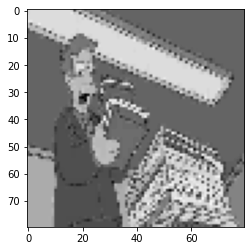

In [30]:
import matplotlib.pyplot as plt
plt.imshow(train[0][0], cmap='gray');

In [31]:
featureSet,labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [32]:
from tensorflow.keras.utils import to_categorical
# Normalize the featureSet ==> (0,1)
featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(characters))

In [33]:
x_train,x_val,y_train,y_val = caer.train_val_split(featureSet, labels, val_ratio=2)

In [34]:
del train
del featureSet
del labels
gc.collect()

23

In [35]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [36]:
BATCH_SIZE = 32
EPOCHS = 10

In [37]:
# Image data generator
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_val,y_val, batch_size=BATCH_SIZE)

In [38]:
# Creating Model
model = canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE, channels=channels, output_dim=len(characters),loss='binary_crossentropy', decay=1e-6, learning_rate=0.001, momentum=0.9, nesterov=True)

In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 80, 80, 32)        320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 78, 78, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 39, 39, 64)        18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 18, 64)       

In [40]:
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]

In [41]:
training = model.fit(train_gen,
                    steps_per_epoch=len(x_val)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks=callbacks_list)

Epoch 1/10
431/431 [==============================] - 18s 40ms/step - loss: 0.3399 - accuracy: 0.1548 - val_loss: 0.3306 - val_accuracy: 0.1626
Epoch 2/10
431/431 [==============================] - 15s 34ms/step - loss: 0.3235 - accuracy: 0.1616
Epoch 3/10
431/431 [==============================] - 14s 32ms/step - loss: 0.3226 - accuracy: 0.1618
Epoch 4/10
431/431 [==============================] - 15s 36ms/step - loss: 0.3141 - accuracy: 0.1987
Epoch 5/10
431/431 [==============================] - 15s 34ms/step - loss: 0.3050 - accuracy: 0.2435
Epoch 6/10
431/431 [==============================] - 14s 32ms/step - loss: 0.3028 - accuracy: 0.2514
Epoch 7/10
431/431 [==============================] - 14s 33ms/step - loss: 0.2999 - accuracy: 0.2666
Epoch 8/10
431/431 [==============================] - 14s 33ms/step - loss: 0.2964 - accuracy: 0.2777
Epoch 9/10
431/431 [==============================] - 14s 33ms/step - loss: 0.2943 - accuracy: 0.2862
Epoch 10/10
431/431 [===================

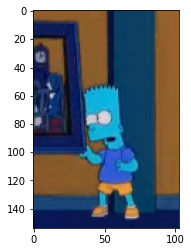

In [51]:
test_path = r'../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/bart_simpson_20.jpg'

img = cv2.imread(test_path)
plt.imshow(img);

In [52]:
def prepare(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE)
    img = caer.reshape(img, IMG_SIZE, 1)
    return img

In [53]:
prediction = model.predict(prepare(img))

In [54]:
print(characters[np.argmax(prediction[0])])

lisa_simpson
